In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import astra
astra.set_gpu_index((0, 1, 2, 3))
import odl
import pylab

from AdversarialRegularizer import AdversarialRegulariser
from AdversarialRegularizer_FoV import AdversarialSplitting
from networks_FoV import ResNetL2, ResNetL2_local
from ut import unify_form
from networks import AlexNet_3D
from ellipsgen.generate_data_function import get_batch
import numpy as np
import ellipsgen.CCB_class as CT
import ellipsgen.phantom_class as ph
import matplotlib.pyplot as plt


IMG_SIZE = 128
STEPS = 100

In [2]:
# Parameter choices. Heuristic in the BWGAN paper: Choose GAMMA as average dual norm of clean image
# LMB should be bigger than product of norm times dual norm.

# For s=0.0, this implies GAMMA =1.0
# For s=1.0, have GAMMA = 10.0 as realisitc value
S = 0.0
LMB = 10.0
GAMMA = 1.0
CUTOFF = 20.0

saves_path = '/export/scratch1/home/voxels-gpu0/codesprint_learned_prior/AdvRegSaves/FoV_experiments'
regularizer = AdversarialSplitting(saves_path, NETWORK=ResNetL2_local, BATCH_SIZE=1)
#regularizer = AdversarialRegulariser(saves_path, IMAGE_SIZE=(None, IMG_SIZE, IMG_SIZE, IMG_SIZE, 1), NETWORK=AlexNet_3D,
#                                     s=S, cutoff=CUTOFF, lmb=LMB, gamma=GAMMA)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv3d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.average_pooling3d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
No save found


In [3]:
class Objective:
    def __init__(self, reg: AdversarialRegulariser, CT_obj, reg_lambda=1):
        self._reg = reg
        self._CT_obj = CT_obj
        self._reg_lambda = reg_lambda
        self._x = None
        
        self.precompute_data_gradient(self._CT_obj.g)
    
    def precompute_data_gradient(self, data):
        # In each gradient we need A*y, so lets just precompute it
        self._AT_y = self._CT_obj.FwP.adjoint(data)
        # self._CT_obj.show(self._AT_y)
    
    def __call__(self, x):
        self._x = x
        
        return self 
            
    def value(self):
        # compute ||Fx - d|| + lambda * R
        pass
    
    @property
    def x(self):
        if self._x is not None:
            return self._x
        else:
            raise Exception("Call Misfit with x first.")
    
    def gradient(self, show=False):
        grad_reg = self._reg.evaluate(self._x)
        grad_misfit = self._CT_obj.FwP.adjoint(self._CT_obj.FwP(self.x)) - self._AT_y
        
        if show:
            plot(grad_reg, title="grad(R)")
            plot(grad_misfit, title="A*Ax - A*y")
        
        return self._reg_lambda * grad_reg + grad_misfit

    
def plot(x, title=None, fontsize=20):
#     mid = np.size(rec, 0) // 2
#     xy, xz, yz = [rec[:, :, mid], rec[:, mid, :], rec[mid, :, :]]
#     fig, (ax1, ax2, ax3) = pylab.subplots(1, 3, figsize=[20, 6])
#     fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
#     ima = ax1.imshow(np.rot90(xy), cmap='gray')
#     ax1.set_xticks([],[])
#     ax1.set_yticks([],[])
#     ax1.set_xlabel('x', fontsize=fontsize)
#     ax1.set_ylabel('y', fontsize=fontsize)
#     ima = ax2.imshow(np.rot90(xz), cmap='gray')
#     ax2.set_xticks([],[])
#     ax2.set_yticks([],[])
#     ax2.set_xlabel('x', fontsize=fontsize)
#     ax2.set_ylabel('z', fontsize=fontsize)
#     ima = ax3.imshow(np.rot90(yz), cmap='gray')
#     ax3.set_xlabel('y', fontsize=fontsize)
#     ax3.set_ylabel('z', fontsize=fontsize)
#     ax3.set_xticks([],[])
#     ax3.set_yticks([],[])
#     fig.colorbar(ima, ax=(ax1, ax2, ax3))

#     fig.suptitle(title, fontsize=fontsize+2)
#     fig.show()
    
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(x[..., x.shape[0]//2])
    plt.colorbar()
    plt.show()
    
    
def generate_pair():
    num_angles = 360
    noise = ['Poisson', 2 ** 14] # Do not go below 2 ** 8, lower number in the 2nd argument means more noise
    num_vox = IMG_SIZE
    voxels = [num_vox, num_vox, num_vox]
    src_rad = 10
    det_rad = 0

    data_obj = ph.phantom(voxels, '22 Ellipses', num_angles, noise, src_rad, det_rad)
    gt =  data_obj.f

    case = CT.CCB_CT(data_obj)
    fdk = case.do_FDK()
        
    plt.figure()
    plt.imshow(gt[int(IMG_SIZE/2), ...])
    plt.show()

    plt.figure()
    plt.imshow(fdk[int(IMG_SIZE/2), ...])
    plt.show()

    return (gt, fdk)

def generate_CT_obj():
    num_vox = IMG_SIZE
    num_angles = 360
    noise = ['Poisson', 2 ** 14] 
    voxels = [num_vox, num_vox, num_vox]
    src_rad = 10
    det_rad = 0
    data_obj = ph.phantom(voxels, '22 Ellipses', num_angles, noise,
                          src_rad, det_rad)
    case = CT.CCB_CT(data_obj)
    return case

def frob(x: np.ndarray):
    return np.sum(x**2) 

def iterative_gradient_descent(x, alpha, objective: Objective, iters=10):    
    hist = []
    for i in range(iters):
        g = objective(x).gradient(show=(i%15==0)).asarray()
        hist.append(frob(g))
    
        # update step
        np.add(x, np.multiply(alpha, -g, out=g), out=x)
        if i % 15 == 0:
            plot(x)

            plt.figure(679327)
            plt.title("History ||G||_F")
            plt.plot(hist)
            plt.show()
    
    return x

In [4]:
CT_obj = generate_CT_obj()
alpha = 0.9 * odl.power_method_opnorm(CT_obj.FwP, maxiter=6) ** (-2)
alpha /= 1
x = np.ones((IMG_SIZE, IMG_SIZE, IMG_SIZE))
obj = Objective(regularizer, CT_obj, reg_lambda=1e3)

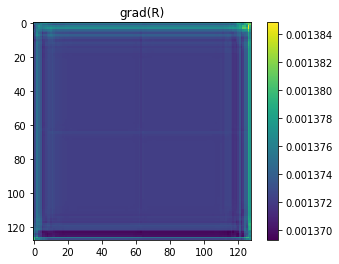

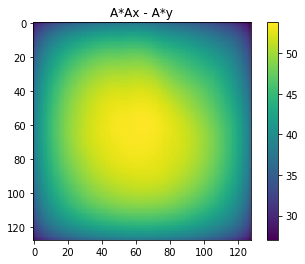

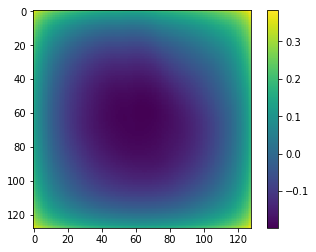

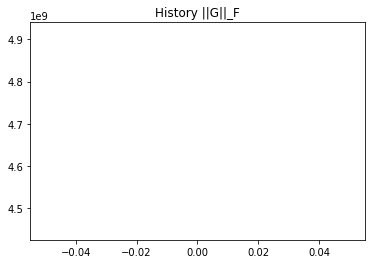

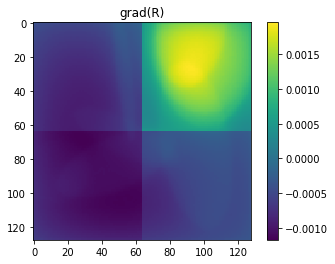

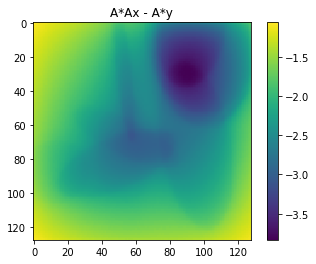

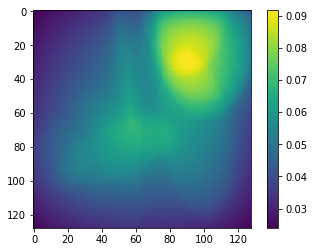

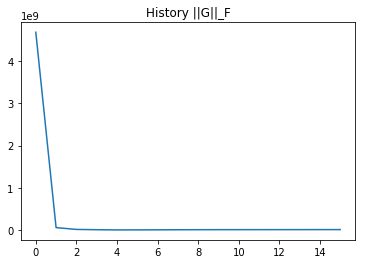

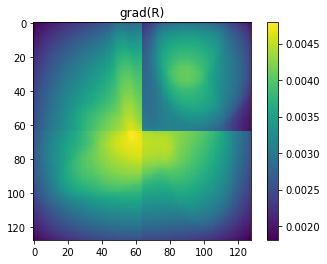

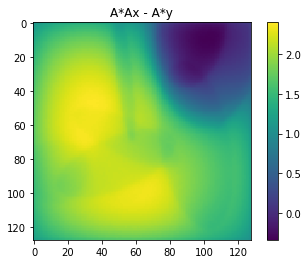

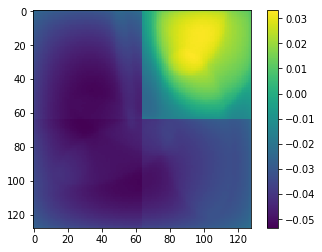

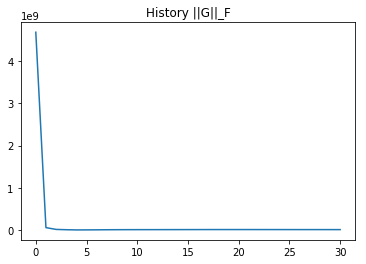

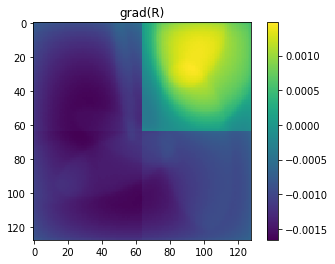

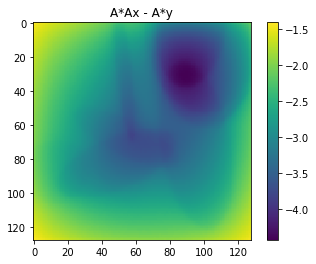

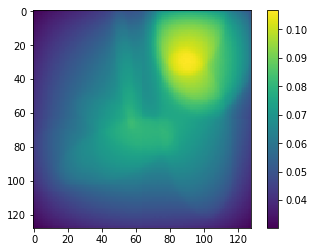

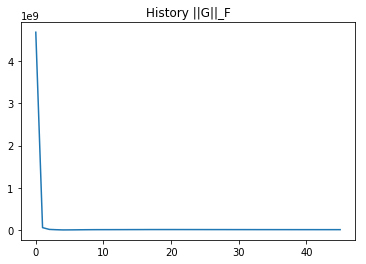

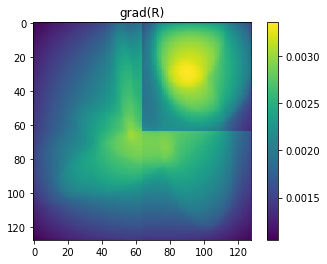

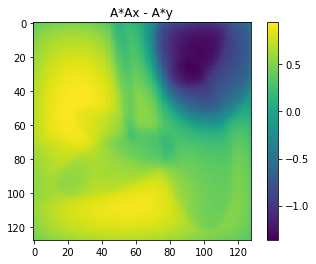

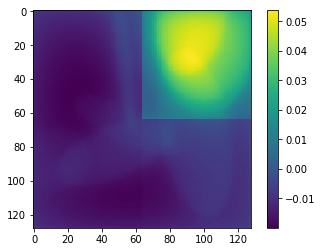

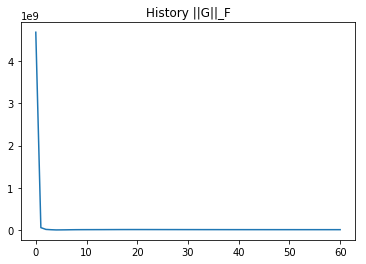

In [ ]:
iterative_gradient_descent(x, alpha, obj, iters=200)